# Hierarchical Swarms
## Time taken in different states
In these set of experiments, we study the amount of time taken by the dog swarm to have the sheep swarm form a shape and move them over a 10 meter distance. 
Ideally there are 4 main coordinated state transitions performed by the dog swarm. We use these state transition time stamps to identify the time taken.

In [10]:
# Import the necessary Python libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import log10
import math
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import os.path
import csv
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [11]:
DATA_DIR = "/SR/data"

In [51]:
# Dog states
TASK_ALLOCATION=10
DENSITY_CONFIG=11
SHAPE_GOAL=12
SHAPING=13
MISSION=14
STAND_BY=15
STATES=[TASK_ALLOCATION,SHAPE_GOAL,SHAPING,MISSION]

In [117]:
SHEEP = [50,100,300]
DOG = [4,8,16]
N_DOG =[9,9,17]
SHAPE = [0,1,2] # clover, dumbbell, none
MOVEMENT = [0,1] # streight, diagonal
REP=30
TIME_STEP = 10

## Data file Header 
robot id(1), yaw(2), CoM_x(3), CoM_y(4), u_dist_contribution_x, u_dist_contribution_y, u_ang_contribution_x, u_ang_contribution_y, u_target_x, u_target_y, stored_ang_diff, cur_ang, mode, sub_mode.

In [207]:
print("EXPERIMENTAL DATA FILES STATS")
for robot in range(0,3):
    for shape in [0,1,2]:
        dog_list = DOG
        if(shape == 2):
            dog_list = N_DOG
        for movement in [0]:
            for rep in range(1,REP+1):
                if not os.path.exists(DATA_DIR+"/pos_"+str(SHEEP[robot])+'_'+str(dog_list[robot])+'_'+str(shape)+'_'+str(movement)+'_'+str(rep)+'.csv'):
                    print("EXP: SHEEP {} DOG {} shape {} movement {} rep {} does not exist".format(SHEEP[robot],dog_list[robot],shape, movement,rep))
                    print(DATA_DIR+"/pos_"+str(SHEEP[robot])+'_'+str(dog_list[robot])+'_'+str(shape)+'_'+str(movement)+'_'+str(rep)+'.csv')
                    
robot = 2
shape = 0
dog_list=DOG
for movement in [1]:
    for rep in range(1,REP+1):
        if not os.path.exists(DATA_DIR+"/pos_"+str(SHEEP[robot])+'_'+str(dog_list[robot])+'_'+str(shape)+'_'+str(movement)+'_'+str(rep)+'.csv'):
            print("EXP: SHEEP {} DOG {} shape {} movement {} rep {} does not exist".format(SHEEP[robot],dog_list[robot],shape, movement,rep))
            print(DATA_DIR+"/pos_"+str(SHEEP[robot])+'_'+str(dog_list[robot])+'_'+str(shape)+'_'+str(movement)+'_'+str(rep)+'.csv')

EXPERIMENTAL DATA FILES STATS
EXP: SHEEP 300 DOG 16 shape 0 movement 0 rep 28 does not exist
/SR/data/pos_300_16_0_0_28.csv


In [105]:
def get_names(robot):
    name = ['time_step']
    for i in range(1000,1000+robot):
        name.append('id_'+str(i))
        name.append('yaw_'+str(i))
        name.append('cx_'+str(i))
        name.append('cy_'+str(i))
        name.append('px_'+str(i))
        name.append('py_'+str(i))
        name.append('ax_'+str(i))
        name.append('ay_'+str(i))
        name.append('tx_'+str(i))
        name.append('ty_'+str(i))
        name.append('sang_'+str(i))
        name.append('cang_'+str(i))
        name.append('m_'+str(i))
        name.append('sm_'+str(i))
    return name

In [106]:
# Reads the data of a single experiment
def read_dog_datafile(name, dogs_num):
    fname = DATA_DIR + "/" + name
    print(fname)
    names = get_names(dogs_num)
#     print tmp
    return pd.read_csv(fname, names=names, header=None, skiprows=0, engine='python')

In [107]:
c_df = read_datafile("dogVars_50_4_0_0_18.csv", 4)

/SR/data/dogVars_50_4_0_0_18.csv


In [108]:
def obtain_state_times(c_df, dogs):
    state_times=[]
    for s in range(1,len(STATES)):
        largest_state_Time = 0
        for d in range(1000,1000+dogs):
            stateTime = c_df[c_df['m_'+str(d)]==STATES[s]].index.tolist()
            if(stateTime[0] > largest_state_Time):
                largest_state_Time = stateTime[0]
        state_times.append(largest_state_Time)
    state_times.append(len(c_df))
    return state_times

In [109]:
def obtain_state_times_all_runs(robots, shape, movement):
    # Collect data
    Total_times=[]
    dog_list=DOG
    if(shape == 2):
        dog_list=N_DOG
    for i in range(1,REP+1):
        fname = 'dogVars_'+str(SHEEP[robots])+'_'+str(dog_list[robots])+'_'+str(shape)+'_'+str(movement)+'_'+str(i)+'.csv'
        c_df = read_dog_datafile(fname, dog_list[robots])
        state_Time = obtain_state_times(c_df, dog_list[robots])
        Total_times.append(state_Time)
    return Total_times

In [210]:
# Makes a series of raw data out of a set of experiments
def static_make_series_data(robots, shape, movement, state, all_time):
    # Create series to contain the result
    res = pd.Series()
    res.set_value(0, SHEEP[robots])
    res.set_value(1, shape)
    res.set_value(2, movement)
    res.set_value(3, state)
    for i in range(0,REP):
        res.set_value(i+4, all_time[i][state])
    return res

# Makes a complete table of raw data
def static_make_table_data():
    # Store data here
    df = pd.DataFrame()
    # Fill in the data, one series at a time
    for robots in range(0,3):
        for shape in SHAPE:
            for movement in [0]:
                all_time=obtain_state_times_all_runs(robots,shape,movement)
                for state in range(0,len(STATES)):
                    df = df.append(static_make_series_data(robots, shape, movement, state, all_time), ignore_index=True)
    
    robot = 2
    shape = 0
    dog_list=DOG
    for movement in [1]:
        all_time=obtain_state_times_all_runs(robots,shape,movement)
        for state in range(0,len(STATES)):
            df = df.append(static_make_series_data(robots, shape, movement, state, all_time), ignore_index=True)
    # Return the dataframe
    df.set_index([0, 1, 2, 3], inplace=True)
    df.index.names = ["robots", "shape", "movement", "State"]
    df.columns = range(1, REP+1)
    return df

In [211]:
data = static_make_table_data()

/SR/data/dogVars_50_4_0_0_1.csv
/SR/data/dogVars_50_4_0_0_2.csv
/SR/data/dogVars_50_4_0_0_3.csv
/SR/data/dogVars_50_4_0_0_4.csv
/SR/data/dogVars_50_4_0_0_5.csv
/SR/data/dogVars_50_4_0_0_6.csv
/SR/data/dogVars_50_4_0_0_7.csv
/SR/data/dogVars_50_4_0_0_8.csv
/SR/data/dogVars_50_4_0_0_9.csv
/SR/data/dogVars_50_4_0_0_10.csv
/SR/data/dogVars_50_4_0_0_11.csv
/SR/data/dogVars_50_4_0_0_12.csv
/SR/data/dogVars_50_4_0_0_13.csv
/SR/data/dogVars_50_4_0_0_14.csv
/SR/data/dogVars_50_4_0_0_15.csv
/SR/data/dogVars_50_4_0_0_16.csv
/SR/data/dogVars_50_4_0_0_17.csv
/SR/data/dogVars_50_4_0_0_18.csv
/SR/data/dogVars_50_4_0_0_19.csv
/SR/data/dogVars_50_4_0_0_20.csv
/SR/data/dogVars_50_4_0_0_21.csv
/SR/data/dogVars_50_4_0_0_22.csv
/SR/data/dogVars_50_4_0_0_23.csv
/SR/data/dogVars_50_4_0_0_24.csv
/SR/data/dogVars_50_4_0_0_25.csv
/SR/data/dogVars_50_4_0_0_26.csv
/SR/data/dogVars_50_4_0_0_27.csv
/SR/data/dogVars_50_4_0_0_28.csv
/SR/data/dogVars_50_4_0_0_29.csv
/SR/data/dogVars_50_4_0_0_30.csv
/SR/data/dogVars_50

/SR/data/dogVars_300_17_2_0_5.csv
/SR/data/dogVars_300_17_2_0_6.csv
/SR/data/dogVars_300_17_2_0_7.csv
/SR/data/dogVars_300_17_2_0_8.csv
/SR/data/dogVars_300_17_2_0_9.csv
/SR/data/dogVars_300_17_2_0_10.csv
/SR/data/dogVars_300_17_2_0_11.csv
/SR/data/dogVars_300_17_2_0_12.csv
/SR/data/dogVars_300_17_2_0_13.csv
/SR/data/dogVars_300_17_2_0_14.csv
/SR/data/dogVars_300_17_2_0_15.csv
/SR/data/dogVars_300_17_2_0_16.csv
/SR/data/dogVars_300_17_2_0_17.csv
/SR/data/dogVars_300_17_2_0_18.csv
/SR/data/dogVars_300_17_2_0_19.csv
/SR/data/dogVars_300_17_2_0_20.csv
/SR/data/dogVars_300_17_2_0_21.csv
/SR/data/dogVars_300_17_2_0_22.csv
/SR/data/dogVars_300_17_2_0_23.csv
/SR/data/dogVars_300_17_2_0_24.csv
/SR/data/dogVars_300_17_2_0_25.csv
/SR/data/dogVars_300_17_2_0_26.csv
/SR/data/dogVars_300_17_2_0_27.csv
/SR/data/dogVars_300_17_2_0_28.csv
/SR/data/dogVars_300_17_2_0_29.csv
/SR/data/dogVars_300_17_2_0_30.csv
/SR/data/dogVars_300_16_0_1_1.csv
/SR/data/dogVars_300_16_0_1_2.csv
/SR/data/dogVars_300_16_0_1

# Stats on the time take by the dog swarm during 4 state transitions. 

In [212]:
data.stack().groupby(level=[0,1,2,3]).describe().unstack()

count          mean          std    min  \
robots shape movement State                                            
50     0     0        0         30     43.000000     0.000000     43   
                      1         30   2603.866667   231.007051   2220   
                      2         30   3504.566667   253.140915   3094   
                      3         30  17171.500000  5317.756876  14861   
       1     0        0         30     43.000000     0.000000     43   
                      1         30   2245.033333   266.429454   1895   
                      2         30   3230.966667   266.862677   2864   
                      3         30  16101.666667   839.809228  14840   
       2     0        0         30    217.900000    57.073667     98   
                      1         30   3150.800000   325.611933   2746   
                      2         30   4215.366667   360.066898   3758   
                      3         30  15073.633333   501.954901  14235   
100    0     0        0         30    189.300000    49.796240     87   
                      1         30   3880.033333   334.391314   3135   
                      2         30   5178.166667   350.156229   4466   
                      3         30  18410.233333  2550.422516  16530   
       1     0        0         30    189.300000    49.796240     87   
                      1         30   3301.400000   286.924308   2771   
                      2         30   4675.166667   307.367923   4165   
                      3         30  17437.500000   847.513066  16128   
       2     0        0         30    221.933333    60.175567     98   
                      1         30   3743.400000   197.705040   3393   
                      2         30   5043.866667   218.038866   4560   
                      3         30  15579.466667   367.148446  14788   
300    0     0        0         30    453.666667    44.876331    373   
                      1         30   6772.033333   473.990869   5775   
                      2         30   8738.033333   499.010157   7820   
                      3         30  21140.500000  2109.473946  17802   
             1        0         30    456.600000    50.167719    373   
                      1         30   6742.800000   463.077442   5775   
                      2         30   8701.466667   488.069012   7820   
                      3         30  20544.366667  1190.117192  18762   
       1     0        0         30    456.600000    50.167719    373   
                      1         30   5810.633333   365.217600   5013   
                      2         30   7935.466667   394.051610   7045   
                      3         30  22773.000000  3221.572865  19413   
       2     0        0         30    483.000000    50.284021    351   
                      1         30   6212.433333   288.477296   5610   
                      2         30   7578.366667   330.690446   6939   
                      3         30  18380.800000   508.254172  17274   

                                  25%      50%       75%    max  
robots shape movement State                                      
50     0     0        0         43.00     43.0     43.00     43  
                      1       2376.50   2610.0   2801.25   3011  
                      2       3301.75   3485.5   3670.25   4071  
                      3      15437.00  15735.5  16400.00  43977  
       1     0        0         43.00     43.0     43.00     43  
                      1       2040.00   2242.5   2369.25   2989  
                      2       3041.00   3219.5   3341.75   3916  
                      3      15687.75  15948.5  16515.75  18692  
       2     0        0        197.00    219.0    241.00    351  
                      1       2919.75   3071.5   3254.50   4303  
                      2       4002.50   4168.0   4342.50   5318  
                      3      14757.25  14944.0  15366.25  16903  
100    0     0        0        155.75    186.0    219.00    274  
              

In [121]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

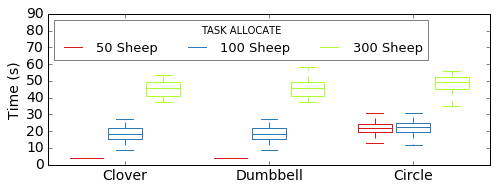

In [130]:

# Create figure and axes
fig = plt.figure(figsize=(7,3))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
# Plot axes
ax = fig.add_subplot(111)

ticks = ['Clover', 'Dumbbell', 'Circle']
robot_1 = []
robot_2 = []
robot_3 = []
for shape in SHAPE:
        robot_1.append((data.stack()[50][shape][0][0]/TIME_STEP))
        robot_2.append((data.stack()[100][shape][0][0]/TIME_STEP))
        robot_3.append((data.stack()[300][shape][0][0]/TIME_STEP))

lin_1 = plt.boxplot(robot_1, positions=np.array(xrange(len(SHAPE)))*3.0-0.8, sym='', widths=0.7)
lin_2 = plt.boxplot(robot_2, positions=np.array(xrange(len(SHAPE)))*3.0, sym='', widths=0.7)
lin_3 = plt.boxplot(robot_3, positions=np.array(xrange(len(SHAPE)))*3.0+0.8, sym='', widths=0.7)


set_box_color(lin_1, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(lin_2, '#2C7BB6')
set_box_color(lin_3, 'GreenYellow')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='50 Sheep')
plt.plot([], c='#2C7BB6', label='100 Sheep')
plt.plot([], c='GreenYellow', label='300 Sheep')

ax.legend(title='TASK ALLOCATE', loc=2,ncol=3,framealpha=0.5,fontsize=13)
plt.xticks([0,3,6], ticks)
plt.xlim(-1.6, 7.6)
plt.ylim(0, 90)
plt.tight_layout(pad=2)

ax.set_ylabel("Time (s)",fontsize=14)
# plt.savefig("/home/vivek/Vivek/Projects/Hierarchical_Swarm/KheperaIV/data_processing/plots/time_taken_state.pdf", dpi=600, format="pdf", transparent=False)

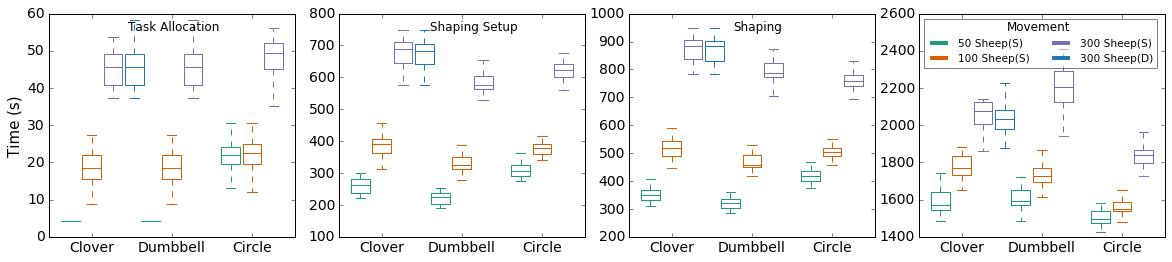

In [221]:
fig, ax = plt.subplots(1, 4,figsize=(20,4))
plt.subplots_adjust(hspace = 0.0,wspace = 0.18)

ticks = ['Clover', 'Dumbbell', 'Circle']
legend_titles = ['Task Allocation', 'Shaping Setup', 'Shaping', 'Movement']
for state in range(0,len(STATES)):
    robot_1 = []
    robot_2 = []
    robot_3 = []
    robot_4 = [] 
    for shape in SHAPE:
            robot_1.append((data.stack()[50][shape][0][state]/TIME_STEP))
            robot_2.append((data.stack()[100][shape][0][state]/TIME_STEP))
            robot_3.append((data.stack()[300][shape][0][state]/TIME_STEP))
            if shape == 0:
                robot_4.append((data.stack()[300][shape][1][state]/TIME_STEP))
            else:
                robot_4.append([])
    lin_1 = ax[state].boxplot(robot_1, positions=np.array(xrange(len(SHAPE)))*3.0-0.8, sym='', widths=0.7)
    lin_2 = ax[state].boxplot(robot_2, positions=np.array(xrange(len(SHAPE)))*3.0, sym='', widths=0.7)
    lin_3 = ax[state].boxplot(robot_3, positions=np.array(xrange(len(SHAPE)))*3.0+0.8, sym='', widths=0.7)
    lin_4 = ax[state].boxplot(robot_4, positions=np.array(xrange(len(SHAPE)))*3.0+1.6, sym='', widths=0.7)
    
    set_box_color(lin_1, '#1b9e77') # colors are from http://colorbrewer2.org/
    set_box_color(lin_2, '#d95f02')
    set_box_color(lin_3, '#7570b3')
    set_box_color(lin_4, '#1f78b4')

    # draw temporary red and blue lines and use them to create a legend
    ax[state].plot([], c='#1b9e77',linewidth=4, label='50 Sheep(S)')
    ax[state].plot([], c='#d95f02',linewidth=4, label='100 Sheep(S)')
    ax[state].plot([], c='#7570b3',linewidth=4, label='300 Sheep(S)')
    ax[state].plot([], c='#1f78b4',linewidth=4, label='300 Sheep(D)')

    #     ax[state].legend(title=legend_titles[state], loc=2,ncol=3,framealpha=0.5,fontsize=13)
    ax[state].set_xticks([0,3,6])
    ax[state].set_xticklabels(ticks)
    ax[state].set_xlim(-1.6,7.6)
# legend for last state only
ax[3].legend(title='    ', loc=2,ncol=2,framealpha=0.5,fontsize=10.5)   
# y lable for first plot
ax[0].set_ylabel("Time (s)",fontsize=15)
# Add state titles to the plot
plt.figtext(0.18, 0.84, legend_titles[0], color='black', weight='roman',
        size=12)
plt.figtext(0.39, 0.84, legend_titles[1], color='black', weight='roman',
        size=12)
plt.figtext(0.6, 0.84, legend_titles[2], color='black', weight='roman',
        size=12)
plt.figtext(0.79, 0.84, legend_titles[3], color='black', weight='roman',
        size=12)

plt.savefig("/home/vivek/Vivek/Projects/Hierarchical_Swarm/KheperaIV/data_processing/plots/time_taken_state_straight.pdf", dpi=600, format="pdf", transparent=False)

In [222]:
%%bash
pdfcrop /home/vivek/Vivek/Projects/Hierarchical_Swarm/KheperaIV/data_processing/plots/time_taken_state_straight.pdf /home/vivek/Vivek/Projects/Hierarchical_Swarm/KheperaIV/data_processing/plots/time_taken_state_straight.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `/home/vivek/Vivek/Projects/Hierarchical_Swarm/KheperaIV/data_processing/plots/time_taken_state_straight.pdf'.
